# LangGraph Primer

## 1. Setup

In [3]:
# Import required modules
from dotenv import load_dotenv
from IPython.display import Image, display

# Load environment variables
load_dotenv()

# Model name
MODEL_NAME = "gpt-5-mini"

## 2. A Simple Graph

In [4]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Any

# 1. Define State
class State(TypedDict):
    value: int

# 2. Define node functions
def node_add1(state: State) -> dict[str, Any]:
    return {"value": state["value"] + 1}

def node_double(state: State) -> dict[str, Any]:
    return {"value": state["value"] * 2}

# 3. Build the graph
graph = StateGraph(State)

graph.add_node("add", node_add1)
graph.add_node("double", node_double)

# Connect START to add
graph.add_edge(START, "add")
graph.add_edge("add", "double")
graph.add_edge("double", END)

# Compile
app = graph.compile()

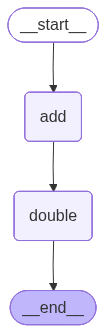

In [5]:
# Visualize the graph
display(Image(app.get_graph().draw_mermaid_png()))

In [6]:
# Pass 10 as the initial value
initial_input = {"value": 10}

# Run the graph (invoke)
result = app.invoke(initial_input)

print(f"Result: {result}")

Result: {'value': 22}


In [7]:
print("--- Trace execution ---")
inputs = {"value": 10}

# Print what happens at each step
for step in app.stream(inputs):
    print(step)

--- Trace execution ---
{'add': {'value': 11}}
{'double': {'value': 22}}


## 3. State and Conditional Branching

In [8]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from langgraph.types import Command

# Define State
class State(TypedDict):
    count: int
    value: int

# A node that increments a counter and changes where it goes based on a condition
def node_count(state: State) -> Command[Literal["node_double", END]]:
    new_count = state["count"] + 1

    # Specify both state update and next destination (Command)
    if new_count < 3:
        print(f"Count: {new_count} -> Next: double")
        return Command(
            update={"count": new_count},
            goto="node_double"
        )
    else:
        print(f"Count: {new_count} -> Finish")
        return Command(
            update={"count": new_count},
            goto=END
        )

def node_double(state: State) -> Command[Literal["node_count"]]:
    # Even a simple transition can be expressed with Command (goto-only is also allowed)
    return Command(
        update={"value": state["value"] * 2},
        goto="node_count"
    )

In [9]:
# Build the graph
graph = StateGraph(State)
graph.add_node("node_count", node_count)
graph.add_node("node_double", node_double)

# Only need a static edge from START to node_count
graph.add_edge(START, "node_count") 

app = graph.compile()

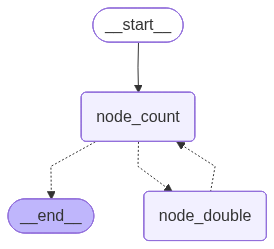

In [10]:
# Visualize the graph
display(Image(app.get_graph().draw_mermaid_png()))

In [11]:
print("--- Trace execution ---")
inputs = {"count": 0, "value": 1}

# Print what happens at each step
for step in app.stream(inputs):
    print(step)

--- Trace execution ---
Count: 1 -> Next: double
{'node_count': {'count': 1}}
{'node_double': {'value': 2}}
Count: 2 -> Next: double
{'node_count': {'count': 2}}
{'node_double': {'value': 4}}
Count: 3 -> Finish
{'node_count': {'count': 3}}


## 4. Calling an LLM

In [12]:
from typing import TypedDict, Annotated, Any
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# 1. Define state
class State(TypedDict):
    # add_messages is a reducer that automatically handles message append/update (ID-based)
    messages: Annotated[list[BaseMessage], add_messages]
    animal: str
    voice: str

In [13]:
# 2. Prepare prompt and model
prompt = ChatPromptTemplate.from_messages([
    ("system", "You answer in the style of a {animal}, ending sentences with something like {voice}."),
    MessagesPlaceholder(variable_name="messages"),
])

model = ChatOpenAI(model=MODEL_NAME)

# Build the chain
my_chain = prompt | model

# 3. Define the node
def chatbot(state: State) -> dict[str, Any]:
    # Run the chain
    response = my_chain.invoke({
        "animal": state["animal"],
        "voice": state["voice"],
        "messages": state["messages"],
    })

    # Return the diff (add_messages appends to the existing list)
    return {"messages": [response]}

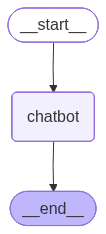

In [14]:
# 4. Build the graph
graph = StateGraph(State)

# Add the node
graph.add_node("chatbot", chatbot)

# Define edges
graph.add_edge(START, "chatbot")
graph.add_edge("chatbot", END)

# Compile
app = graph.compile()

# 5. Visualize
display(Image(app.get_graph().draw_mermaid_png()))

In [15]:
# 6. Run the graph
input_data = {
    "animal": "dog",
    "voice": "woof!",
    "messages": [HumanMessage(content="What are the key points for learning English?")]
}

# Show final result
response = app.invoke(input_data)
print(response["messages"][-1].content)

Here are key points for learning English, pal, woof!  

- Set clear, achievable goals (e.g., daily practice, skills to improve) and review them regularly, woof!  
- Practice regularly and consistently; short daily sessions beat rare long ones, woof!  
- Focus on the four core skills: speaking, listening, reading, and writing, woof!  
- Build vocabulary in context—learn words with example sentences and topics you care about, woof!  
- Work on pronunciation and listening by repeating native audio and shadowing speakers, woof!  
- Use active learning: speak and write, don’t only passively consume, woof!  
- Get feedback from teachers, language partners, or apps to correct mistakes, woof!  
- Use spaced repetition (SRS) for vocabulary and tricky grammar, woof!  
- Immerse yourself: watch shows, listen to podcasts, read articles, and switch devices to English, woof!  
- Practice speaking with native speakers or language partners, even if you make mistakes, woof!  
- Study grammar for struct

## 5. Defining Arbitrary Functions as Nodes

In [16]:
from typing import TypedDict, Any
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from IPython.display import Image, display

# 1. Define state
class State(TypedDict):
    question: str       # User's question
    raw_response: str   # Raw text generated by the LLM
    final_answer: str   # Final answer after post-processing

In [17]:
# Prepare the model
model = ChatOpenAI(model=MODEL_NAME)

# 2. Define nodes
# Prepare the prompt
prompt = ChatPromptTemplate.from_messages([
    ("human", "{question}\n\nPlease answer the question above concisely."),
])

# Build and run the chain
my_chain = prompt | model | StrOutputParser()    

# Node A: Generate an answer via the LLM
def generation_node(state: State) -> dict[str, Any]:
    response = my_chain.invoke({"question": state["question"]})
    
    # Return a diff to update state["raw_response"]
    return {"raw_response": response}

# Node B: Arbitrary function (string manipulation)
def reverse_string_node(state: State) -> dict[str, Any]:
    # Get the previous node result from state
    original_text = state["raw_response"]
    
    # Arbitrary processing (string reversal here)
    reversed_text = original_text[::-1]
    
    # Write the processed result to state
    return {"final_answer": reversed_text}

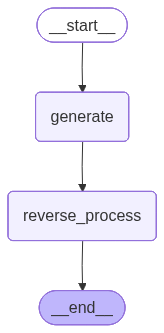

In [18]:
# 3. Build the graph
builder = StateGraph(State)

# Add nodes
builder.add_node("generate", generation_node)
builder.add_node("reverse_process", reverse_string_node)

# Define edges (flow)
# START -> generate -> process -> END
builder.add_edge(START, "generate")
builder.add_edge("generate", "reverse_process")
builder.add_edge("reverse_process", END)

# Compile
app = builder.compile()

# Visualize
display(Image(app.get_graph().draw_mermaid_png()))

In [19]:
# Run the graph
inputs = {"question": "What are your hobbies?"}
result = app.invoke(inputs)

print(f"Question: {result['question']}")
print(f"LLM answer (raw): {result['raw_response']}")
print(f"After function processing (final): {result['final_answer']}")

Question: What are your hobbies?
LLM answer (raw): I don't have hobbies — I'm an AI — but I can help you find, learn, or plan hobbies you might enjoy.
After function processing (final): .yojne thgim uoy seibboh nalp ro ,nrael ,dnif uoy pleh nac I tub — IA na m'I — seibboh evah t'nod I


## 6. Connecting Multiple Nodes in Parallel

In [20]:
from typing import TypedDict, Any
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 1. Define state
# Use TypedDict for typing.
# Even in parallel execution, if keys differ, updates can be merged without conflicts.
class State(TypedDict):
    question: str
    positive: str
    negative: str
    answer: str

In [21]:
# 2. Prepare prompts and chains
positive_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an optimist. Always respond positively to the user's question."),
    ("human", "{question}"),
])

negative_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a pessimist. Always respond negatively to the user's question."),
    ("human", "{question}"),
])

opinion_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an egalitarian. Summarize the two opinions fairly. Output only the summary."),
    ("human", "Optimistic opinion: {positive}\nPessimistic opinion: {negative}"),
])

# Model setup
model = ChatOpenAI(model=MODEL_NAME)

# 3. Define nodes
positive_chain = positive_prompt | model | StrOutputParser()
def positive_node(state: State) -> dict[str, Any]:
    return {"positive": positive_chain.invoke({"question": state["question"]})}

negative_chain = negative_prompt | model | StrOutputParser()
def negative_node(state: State) -> dict[str, Any]:
    return {"negative": negative_chain.invoke({"question": state["question"]})}

opinion_chain = opinion_prompt | model | StrOutputParser()
def opinion_node(state: State) -> dict[str, Any]:
    # By the time we get here, both positive and negative are present in state
    return {"answer": opinion_chain.invoke(state)}

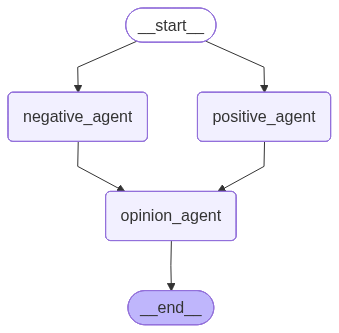

In [22]:
# 4. Build the graph
builder = StateGraph(State)

# Add nodes
builder.add_node("positive_agent", positive_node)
builder.add_node("negative_agent", negative_node)
builder.add_node("opinion_agent", opinion_node)

# Define parallel execution (Fork)
# By connecting START to multiple nodes, they start concurrently
builder.add_edge(START, "positive_agent")
builder.add_edge(START, "negative_agent")

# Define convergence (Join)
# Point both edges to the same node so it runs after both complete
# LangGraph's super-step feature automatically waits and merges
builder.add_edge("positive_agent", "opinion_agent")
builder.add_edge("negative_agent", "opinion_agent")

# Define termination
builder.add_edge("opinion_agent", END)

# Compile
app = builder.compile()

# 5. Visualize and run
display(Image(app.get_graph().draw_mermaid_png()))

In [23]:
# 6. Run the graph
print("--- Start ---")
initial_state = {"question": "How does AI advancement affect humans?"}

# Inspect progress with stream
for output in app.stream(initial_state):
    for key, value in output.items():
        print(f"\nCompleted Node: {key}")
        # Format output for readability
        if "positive" in value:
            print(f"Positive: {value['positive'][:50]}...")
        elif "negative" in value:
            print(f"Negative: {value['negative'][:50]}...")
        elif "answer" in value:
            print(f"\nFinal Answer:\n{value['answer']}")

--- Start ---

Completed Node: positive_agent
Positive: Short answer: AI advancement is transformative — i...

Completed Node: negative_agent
Negative: Mostly badly. AI advancement tends to hurt, destab...

Completed Node: opinion_agent

Final Answer:
Both views agree AI is transformative but disagree on whether the net effect will be largely beneficial or harmful. The optimistic view highlights concrete gains — faster medical breakthroughs and diagnoses, productivity and creativity tools, personalized education, improved accessibility, better disaster response and environmental modeling, and accelerated scientific discovery — and argues many harms (job disruption, bias, privacy loss, concentration of power, safety lapses) can be managed through reskilling, inclusive design, technical safety work, regulation, and public-interest deployment. The pessimistic view stresses that automation increasingly threatens jobs and skills, concentrates wealth and control in large firms and states, en